In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import joblib



In [4]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [5]:
# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [5]:

# Create a pipeline with TF-IDF vectorization and SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', SVC(class_weight='balanced'))
])

# Use smaller param grid for quick testing
quick_param_grid = {
    'classifier__C': [1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

# Perform grid search to find best parameters
print("\nPerforming grid search...")
grid_search = GridSearchCV(pipeline, quick_param_grid, cv=5, scoring='f1_macro', verbose=1)
grid_search.fit(X_train, y_train)


Performing grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        ngram_range=(1, 2))),
                                       ('classifier',
                                        SVC(class_weight='balanced'))]),
             param_grid={'classifier__C': [1, 10],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='f1_macro', verbose=1)

In [6]:
from sklearn.metrics import confusion_matrix, f1_score

# Get best model
best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")

# Evaluate on validation set
y_pred = best_model.predict(X_val)

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_weighted = f1_score(y_val, y_pred, average='weighted')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"Weighted F1 Score: {validation_f1_weighted:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Best parameters: {'classifier__C': 1, 'classifier__kernel': 'rbf'}

Validation set performance:
              precision    recall  f1-score   support

          -1       0.86      0.85      0.86      2926
           0       0.44      0.37      0.40       502
           1       0.63      0.70      0.67      1073

    accuracy                           0.76      4501
   macro avg       0.65      0.64      0.64      4501
weighted avg       0.76      0.76      0.76      4501

Accuracy: 0.7636
Macro F1 Score: 0.6418
Weighted F1 Score: 0.7617
F1 Score per class:
  Not Factual: 0.8587
  Unimportant Fact: 0.4000
  Important Fact: 0.6667


Confusion matrix saved as 'confusion_matrix.png'


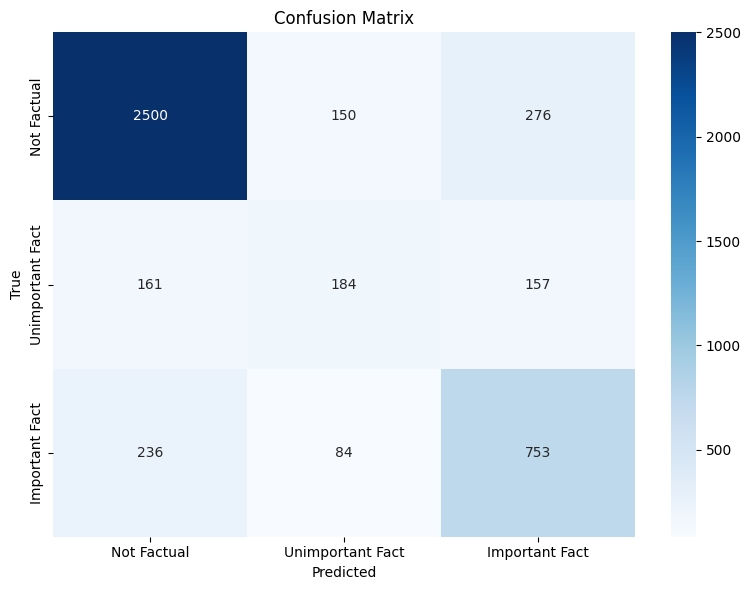

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [8]:
# Train on full training data with best parameters
print("\nTraining final model on all training data...")
best_model.fit(X, y)


Training final model on all training data...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier', SVC(C=1, class_weight='balanced'))])

In [9]:
# Save the model
joblib.dump(best_model, 'svm_model.pkl')
print("Model saved as 'svm_model.pkl'")

Model saved as 'svm_model.pkl'


In [12]:

# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    
    # Make predictions
    predictions = model.predict(test_data['Text'])
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('svm_model.pkl', 'data/test.csv', 'data/svm_predictions.csv')


Making predictions on test data...
Predictions saved to data/svm_predictions.csv


### Kaggle score: 0.81949


The fact that SVM performs better than Naive Bayes with your imbalanced dataset aligns with machine learning theory - SVM's ability to maximize the margin while incorporating class weights makes it particularly suitable for imbalanced classification problems with clear decision boundaries.

## try with smote 

In [6]:
tfidf = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2),
    lowercase=True,
    stop_words='english',
    max_features=1000
)


X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)


In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
smote_class_counts = y_train_resampled.value_counts().sort_index()
print(f"Class -1: {smote_class_counts.get(-1, 0)} samples")
print(f"Class 0: {smote_class_counts.get(0, 0)} samples")
print(f"Class 1: {smote_class_counts.get(1, 0)} samples")

Class -1: 11759 samples
Class 0: 11759 samples
Class 1: 11759 samples


In [ ]:
svm = SVC(class_weight='balanced')

# Use smaller param grid for quick testing
quick_param_grid = {
    'C': [1],
    'gamma': [0.1, 0.01],
    'kernel': ['rbf']
}

# Perform grid search to find best parameters
print("\nPerforming grid search...")
grid_search = GridSearchCV(svm, quick_param_grid, cv=5, scoring='f1_macro', verbose=3)
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

In [9]:
from sklearn.metrics import confusion_matrix, f1_score

svm = SVC(class_weight='balanced', C=1.0, kernel='rbf', gamma=0.1, random_state=42)

# Get best model
best_model = svm.fit(X_train_tfidf_resampled, y_train_resampled)
# Evaluate on validation set
y_pred = best_model.predict(X_val_tfidf)

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_weighted = f1_score(y_val, y_pred, average='weighted')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"Weighted F1 Score: {validation_f1_weighted:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.81      0.82      0.81      2926
           0       0.31      0.40      0.35       502
           1       0.63      0.54      0.58      1073

    accuracy                           0.70      4501
   macro avg       0.58      0.58      0.58      4501
weighted avg       0.71      0.70      0.71      4501

Accuracy: 0.7034
Macro F1 Score: 0.5811
Weighted F1 Score: 0.7068
F1 Score per class:
  Not Factual: 0.8145
  Unimportant Fact: 0.3482
  Important Fact: 0.5806


Confusion matrix saved as 'confusion_matrix.png'


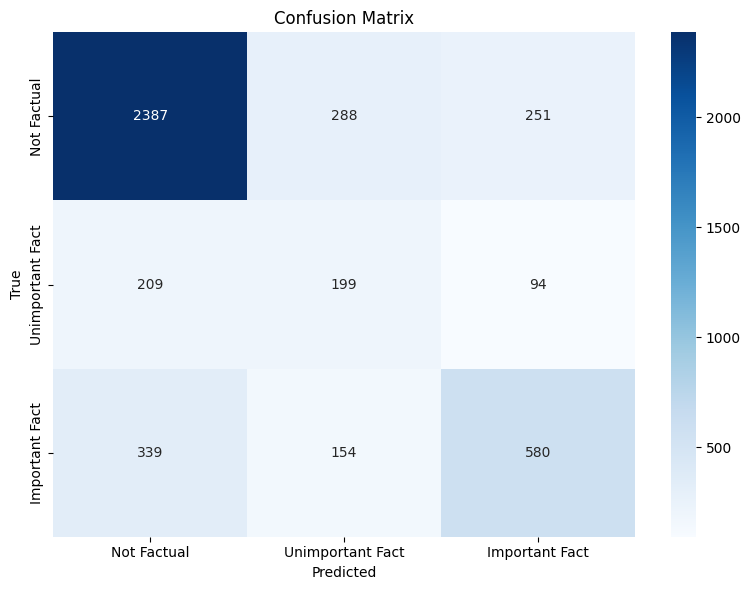

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")